In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

In [ ]:
tf.config.experimental.set_visible_devices(tf.config.experimental.list_physical_devices('GPU'), 'GPU')

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
ages = np.load('eICU_age.npy')
ages = ages['age'].astype(float).reshape(-1,1)
ages.shape

(2520, 1)

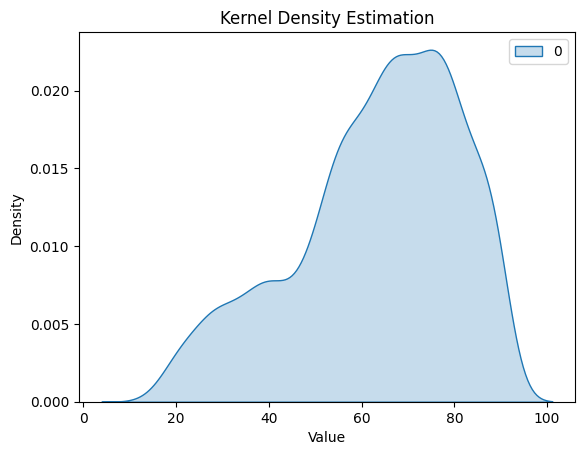

In [ ]:
sns.kdeplot(ages, fill=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Kernel Density Estimation')
plt.show()

In [ ]:
def plot_kde(real, generated, x_axis_label = "Age", title = "KDE Density Plot of Max Values (Real vs Generated)" ):
  sns.set(style="whitegrid")
  plt.figure(figsize=(10, 6))

  kde1 = sns.kdeplot(real, color='red', label="Real", fill=True )
  kde2 = sns.kdeplot(generated, color='green', label="Generated")

  plt.xlabel(x_axis_label)
  plt.ylabel("Density")
  plt.title(title)
  plt.legend()
  plt.show()

In [ ]:
tf.keras.utils.disable_interactive_logging()

Epoch 0/200, Discriminator Loss: 0.6989, Generator Loss: 0.5935
Epoch 10/200, Discriminator Loss: 0.6994, Generator Loss: 0.6255
Epoch 20/200, Discriminator Loss: 0.6974, Generator Loss: 0.5536
Epoch 30/200, Discriminator Loss: 0.6979, Generator Loss: 0.6004
Epoch 40/200, Discriminator Loss: 0.6985, Generator Loss: 0.5947
Epoch 50/200, Discriminator Loss: 0.6982, Generator Loss: 0.5981
Epoch 60/200, Discriminator Loss: 0.6963, Generator Loss: 0.5289
Epoch 70/200, Discriminator Loss: 0.6944, Generator Loss: 0.5738
Epoch 80/200, Discriminator Loss: 0.6957, Generator Loss: 0.5600
Epoch 90/200, Discriminator Loss: 0.6934, Generator Loss: 0.4922
Epoch 100/200, Discriminator Loss: 0.6947, Generator Loss: 0.4978
Epoch 110/200, Discriminator Loss: 0.6940, Generator Loss: 0.5253
Epoch 120/200, Discriminator Loss: 0.6938, Generator Loss: 0.4779
Epoch 130/200, Discriminator Loss: 0.6941, Generator Loss: 0.5252
Epoch 140/200, Discriminator Loss: 0.6924, Generator Loss: 0.4738
Epoch 150/200, Discri

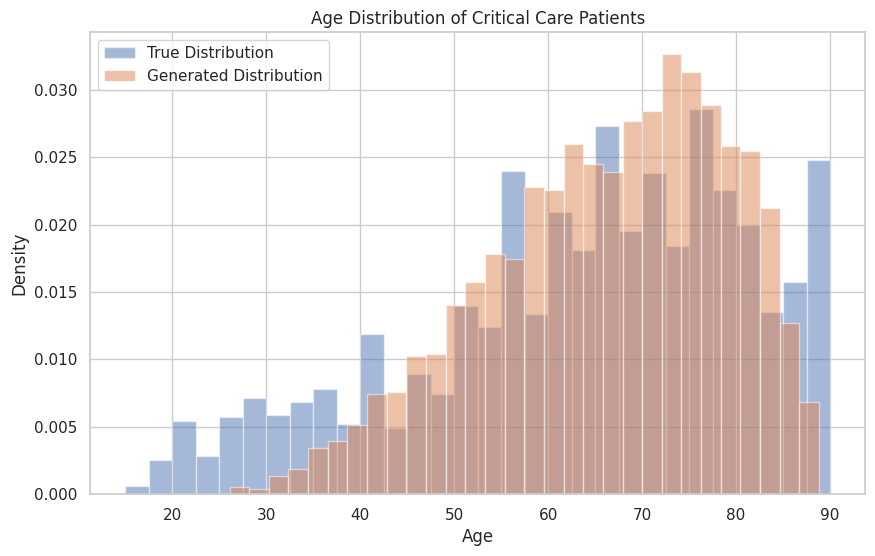

In [319]:
input_dim = 40
# Normalize the data
ages_min, ages_max = np.min(ages), np.max(ages)
normalized_ages = (ages - ages_min) / (ages_max - ages_min)

# Define the generator model
generator = Sequential()
generator.add(Dense(32, input_dim=input_dim, activation='relu'))
# generator.add(Dense(32, activation='relu'))
generator.add(Dense(1, activation='sigmoid'))

# Define the discriminator model
discriminator = Sequential()
discriminator.add(Dense(16, input_dim=1, activation='relu'))
# discriminator.add(Dense(16, activation='relu'))
discriminator.add(Dense(1, activation='sigmoid'))

# Compile the models
generator.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9), loss=binary_crossentropy)
discriminator.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9), loss=binary_crossentropy)

# Train the GAN
batch_size = 256
epochs = 200
losses = []

for epoch in range(epochs):
    # Generate random noise as input for the generator
    noise = np.random.normal(0, 1, size=(batch_size, input_dim))

    # Generate fake samples
    generated_ages = generator.predict(noise) #+ np.random.normal(0, 0.1, size=(batch_size, 1))

    real_indices = np.random.choice(normalized_ages.shape[0], batch_size, replace=False)
    real_ages = normalized_ages[real_indices]

    # Combine real and fake samples
    X = np.concatenate((real_ages, generated_ages), axis=0)
    y_real = np.concatenate((np.ones(batch_size), np.zeros(batch_size)), axis=0)

    # Train the discriminator on the combined dataset
    discriminator_loss = discriminator.train_on_batch(X, y_real)

    # Train the generator to fool the discriminator
    noise = np.random.normal(0, 1, size=(batch_size, input_dim))
    y_fake = np.ones(batch_size)
    generator_loss = generator.train_on_batch(noise, y_fake)
    # Store the losses
    losses.append((discriminator_loss, generator_loss))

    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{epochs}, Discriminator Loss: {discriminator_loss:.4f}, Generator Loss: {generator_loss:.4f}')

# Generate new samples from the trained generator
noise = np.random.normal(0, 1, size=(len(ages), input_dim))
generated_ages = generator.predict(noise)

# Denormalize the real and generated ages
real_ages_denormalized = ages
generated_ages_denormalized = generated_ages * (ages_max - ages_min) + ages_min

# Visualize the true and generated distributions
plt.figure(figsize=(10, 6))
plt.hist(real_ages_denormalized, bins=30, density=True, alpha=0.5, label='True Distribution')
plt.hist(generated_ages_denormalized, bins=30, density=True, alpha=0.5, label='Generated Distribution')
plt.title('Age Distribution of Critical Care Patients')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

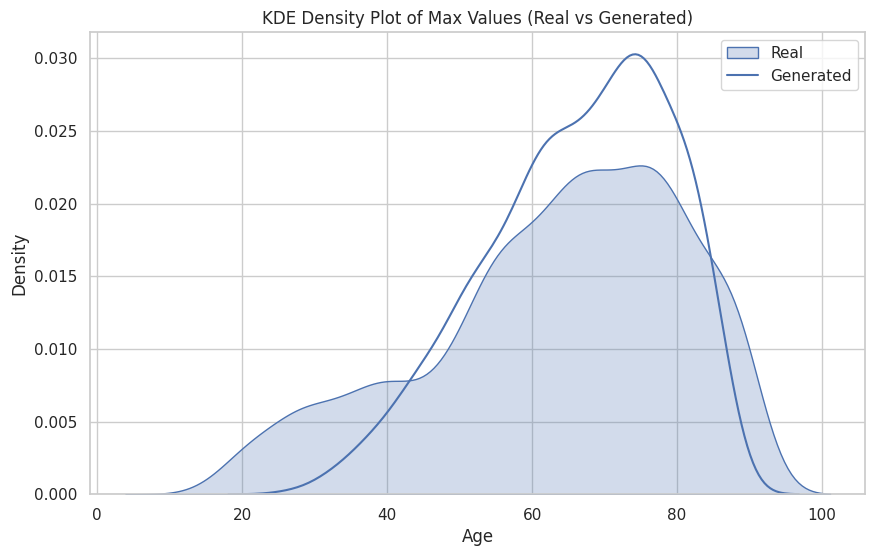

In [320]:
plot_kde(real_ages_denormalized, generated_ages_denormalized)

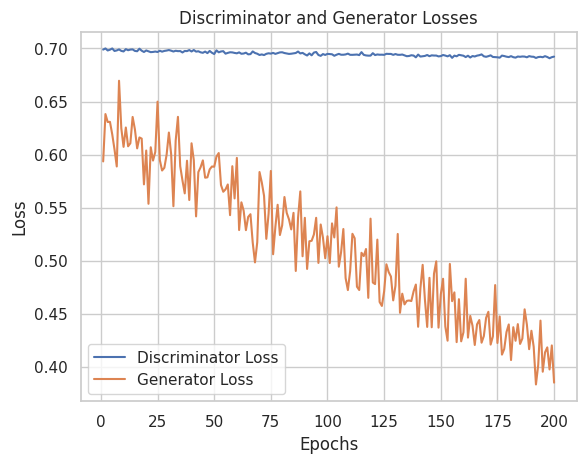

In [323]:
losses = np.array(losses)

plt.plot(np.arange(1, 201), losses[:, 0], label='Discriminator Loss')
plt.plot(np.arange(1, 201), losses[:, 1], label='Generator Loss')

plt.title('Discriminator and Generator Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.grid(True)
plt.show()